In [0]:
import time
import sys
import os
import random
from skimage import io
import collections
from collections import defaultdict
import pandas as pd
from matplotlib import pyplot as plt
from shutil import copyfile
import numpy as np
import cv2
import tensorflow as tf

In [0]:
!git clone https://github.com/skimkoh/cv_dataset.git

Cloning into 'cv_dataset'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 5976 (delta 1), reused 2 (delta 0), pack-reused 5969
Receiving objects: 100% (5976/5976), 134.13 MiB | 46.56 MiB/s, done.
Resolving deltas: 100% (2974/2974), done.
Checking out files: 100% (6576/6576), done.


In [0]:
# read data from csv

import pandas as pd
df = pd.read_csv('dataset.csv')
df = df[~df.filename.str.startswith('mix')]
df.head()


,filename,width,height,class,xmin,ymin,xmax,ymax
0,plum001S(2).JPG,816,612,plum,495,185,677,352
1,doughnut007S(9).JPG,816,612,doughnut,415,258,665,355
2,qiwi006T(2).JPG,816,612,qiwi,337,302,496,477
3,egg006S(7).JPG,816,612,egg,505,258,630,375
4,pear006T(6).JPG,504,378,pear,122,77,277,204


In [0]:
count_class = df.groupby(['class'], sort=False).size().reset_index(name='Count')
count_class

,class,Count
0,plum,176
1,doughnut,210
2,qiwi,120
3,egg,104
4,pear,166
5,apple,296
6,fired_dough_twist,124
7,mango,220
8,lemon,148
9,orange,254


In [0]:
# find the number of images. need to exclude 'mix' 
print('total number of food images: {}'.format(count_class['Count'].sum()))

total number of food images: 2870


In [0]:
# find the number of classes
count = df['class'].unique().shape[0]

print(df['class'].unique())
print('')
print('Number of classes: {}'.format(count))

['plum' 'doughnut' 'qiwi' 'egg' 'pear' 'apple' 'fired_dough_twist' 'mango'
 'lemon' 'orange' 'peach' 'tomato' 'banana' 'sachima' 'grape' 'mooncake'
 'bun' 'litchi' 'bread']

Number of classes: 19


In [0]:
# get boundaries
lst = []
lst.append(df.loc[df.filename == 'apple001S(1).JPG','xmin'].tolist()[0])
lst.append(df.loc[df.filename == 'apple001S(1).JPG','ymin'].tolist()[0])
lst.append(df.loc[df.filename == 'apple001S(1).JPG','xmax'].tolist()[0])
lst.append(df.loc[df.filename == 'apple001S(1).JPG','ymax'].tolist()[0])

lst

[326, 229, 540, 401]

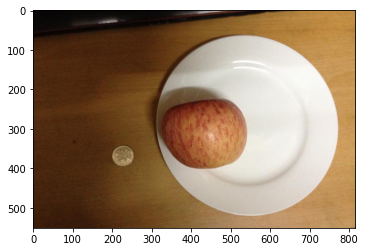

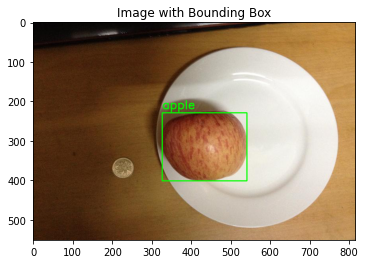

In [0]:
# test show a picture 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('JPEGImages/apple001S(1).JPG')
imgplot = plt.imshow(img)
plt.show()
img_bbox = img.copy()

xmin = int(lst[0])
xmax = int(lst[2])
ymin = int(lst[1])
ymax = int(lst[3])
class_label = df.loc[df['filename'] == 'apple001S(1).JPG', 'class'].iloc[0]
cv2.rectangle(img_bbox,(xmin,ymin),(xmax,ymax),(0,255,0),2)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(img_bbox,class_label,(xmin,ymin-10), font, 1,(0,255,0),2)
cv2.rectangle(img_bbox, (xmin, ymin), (xmax, ymax), (0,255,0), 2)
plt.title('Image with Bounding Box')
plt.imshow(img_bbox)
plt.show()

In [0]:
# multiclass split test/train

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, stratify=df['class'], test_size=0.2)

In [0]:
# number of images in train set per class
count_train = train.groupby(['class'], sort=False).size().reset_index(name='Count')
count_train

,class,Count
0,doughnut,168
1,plum,141
2,pear,133
3,banana,143
4,tomato,138
5,lemon,118
6,fired_dough_twist,99
7,peach,101
8,orange,203
9,mango,176


In [0]:
# number of images in test set per class

count_test = test.groupby(['class'], sort=False).size().reset_index(name='Count')
count_test

,class,Count
0,mango,44
1,banana,35
2,apple,59
3,plum,35
4,qiwi,24
5,orange,51
6,litchi,16
7,mooncake,27
8,sachima,30
9,doughnut,42


In [0]:
# to create a test/train folder

if not os.path.exists('test'):
  os.makedirs('test')

if not os.path.exists('train'):
  os.makedirs('train') 

In [0]:
for food_class in sorted(df['class'].unique()):
  if not os.path.exists(os.path.join('test', food_class)):
    os.makedirs(os.path.join('test', food_class))
  spec_food = test.loc[test['class'] == food_class]
  lst = spec_food['filename'].tolist()
  for i in lst: 
    filename = os.path.basename(i)
    copyfile(os.path.join('JPEGImages', i), os.path.join('test', food_class, filename))

In [0]:
for food_class in sorted(df['class'].unique()):
  if not os.path.exists(os.path.join('train', food_class)):
    os.makedirs(os.path.join('train', food_class))
  spec_food = train.loc[train['class'] == food_class]
  lst = spec_food['filename'].tolist()
  for i in lst: 
    filename = os.path.basename(i)
    copyfile(os.path.join('JPEGImages', i), os.path.join('train', food_class, filename))


In [0]:
# # save filenames of photos that belong in train/test 

# np.savetxt(r'train.txt', train['filename'], fmt='%s')
# np.savetxt(r'test.txt', test['filename'], fmt='%s')

In [0]:
# # Helper method to split dataset into train and test folders

# def split_data(txtsrc, src, dest):
#   print('moving images...')
#   with open(txtsrc, 'r') as r:
#     for line in sorted(r):
#       if not os.path.exists(dest):
#         os.makedirs(dest)
#       line = line.rstrip()
#       filename = os.path.basename(line)
#       copyfile(os.path.join(src, line), os.path.join(dest, filename))
#   print('done')

# split_data('train.txt', 'JPEGImages', 'train')
# split_data('test.txt', 'JPEGImages', 'test')

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

classifier = Sequential()
classifier.add(Conv2D(32, (5, 5,), strides=(3, 3), input_shape=(551, 816, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Conv2D(64, (3, 3,), strides=(3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Flatten())
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 19, activation = 'softmax'))

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(551, 816),
    batch_size=32,
    class_mode='categorical')

test_gen = test_datagen.flow_from_directory(
    'test',
    target_size=(551, 816),
    batch_size=32,
    class_mode='categorical')

Found 2296 images belonging to 19 classes.
Found 574 images belonging to 19 classes.


In [0]:
from keras import backend as K
K.clear_session()

In [0]:
from IPython.display import display
from PIL import Image

classifier.fit(
    train_generator,
    epochs = 10
)

Epoch 1/10
72/72 [==============================] - 223s 3s/step - loss: 2.8743 - acc: 0.1084
Epoch 2/10
72/72 [==============================] - 221s 3s/step - loss: 2.4264 - acc: 0.2623
Epoch 3/10
72/72 [==============================] - 217s 3s/step - loss: 1.7329 - acc: 0.4463
Epoch 4/10
72/72 [==============================] - 216s 3s/step - loss: 1.3514 - acc: 0.5558
Epoch 5/10
72/72 [==============================] - 215s 3s/step - loss: 1.0953 - acc: 0.6460
Epoch 6/10
72/72 [==============================] - 215s 3s/step - loss: 0.8703 - acc: 0.7193
Epoch 7/10
72/72 [==============================] - 215s 3s/step - loss: 0.7218 - acc: 0.7603
Epoch 8/10
72/72 [==============================] - 215s 3s/step - loss: 0.6373 - acc: 0.7988
Epoch 9/10
72/72 [==============================] - 214s 3s/step - loss: 0.5437 - acc: 0.8328
Epoch 10/10
72/72 [==============================] - 214s 3s/step - loss: 0.4707 - acc: 0.8501


In [0]:
# test on the test data
# format: ['loss', 'acc']
classifier.evaluate_generator(test_gen)

[2.9566374830252617, 0.059233449659073394]

In [0]:
# save the model

classifier_json = classifier.to_json()
with open("classifier.json", "w") as json_file:
    json_file.write(classifier_json)
# serialize weights to HDF5
classifier.save_weights("classifier.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
# loading the model
from keras.models import model_from_json
json_file = open('classifier.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
classifer = model_from_json(loaded_model_json)
# load weights into new model
classifer.load_weights("classifier.h5")
print("Loaded model from disk")

# verify the weights are loaded
classifer.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
classifer.evaluate_generator(test_gen)

Loaded model from disk


[0.3833410477181345, 0.8763066189629691]

In [0]:
%ls test/apple

'apple001T(1).JPG'  'apple013T(3).JPG'   'apple017S(11).JPG'
'apple002S(4).JPG'  'apple013T(8).JPG'   'apple017S(16).JPG'
'apple002T(1).JPG'  'apple014S(4).JPG'   'apple017S(1).JPG'
'apple003S(4).JPG'  'apple014S(7).JPG'   'apple017S(21).JPG'
'apple004T(2).JPG'  'apple014T(1).JPG'   'apple017S(25).JPG'
'apple005S(1).JPG'  'apple014T(7).JPG'   'apple017S(6).JPG'
'apple006S(1).JPG'  'apple015S(2).JPG'   'apple017S(9).JPG'
'apple006T(4).JPG'  'apple015S(5).JPG'   'apple017T(10).JPG'
'apple007S(1).JPG'  'apple015T(3).JPG'   'apple017T(13).JPG'
'apple007S(3).JPG'  'apple016S(12).JPG'  'apple017T(23).JPG'
'apple007T(1).JPG'  'apple016S(21).JPG'  'apple017T(3).JPG'
'apple008S(2).JPG'  'apple016S(25).JPG'  'apple017T(6).JPG'
'apple009T(2).JPG'  'apple016S(2).JPG'   'apple018S(10).JPG'
'apple010T(1).JPG'  'apple016S(6).JPG'   'apple018S(5).JPG'
'apple010T(2).JPG'  'apple016S(7).JPG'   'apple018S(7).JPG'
'apple011S(2).JPG'  'apple016S(9).JPG'   'apple018S(9).JPG'
'apple011S(3).JPG'  'apple016T(1

apple017S(21).JPG
banana009T(1).JPG
bread007T(2).JPG
bun001T(6).JPG
doughnut006S(6).JPG
egg006S(6).JPG
fired_dough_twist004T(6).JPG
grape002S(5).JPG
lemon001T(15).JPG
litchi003S(8).JPG
mango006T(7).JPG
mooncake001S(10).JPG
orange010T(1).JPG
peach005S(2).JPG
pear002S(13).JPG
plum001T(19).JPG
qiwi008S(4).JPG
sachima005T(3).JPG
tomato004T(4).JPG
Softmax classification
[[1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 3.8762602e-13 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]


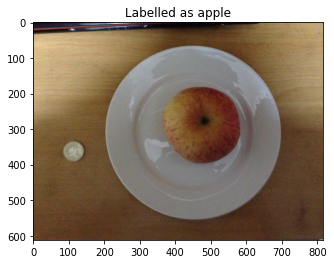

In [0]:
from keras.preprocessing import image

labels = sorted(df['class'].unique())

test_image_path = 'test/apple/apple001T(1).JPG'

test_image = image.load_img(test_image_path, target_size =(551, 816))
# test_image = image.img_to_array(test_image)
# test_image = np.expand_dims(test_image, axis = 0)
# test_image = test_image / 255
# result = classifer.predict(test_image)

# show that the classifier works for one sample data point

result = classifer.predict(np.expand_dims(test_image, axis=0))

print("Softmax classification")
print(result)

# display

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(test_image_path)
imgplot = plt.imshow(img)
plt.title("Labelled as " + labels[np.argmax(result)])
plt.show()

In [0]:
right, tot = 0, 0
for idx, label in enumerate(labels):
  for filename in os.listdir(os.path.join('test', label)):
    test_image_path = os.path.join('test', label, filename)
    test_image = image.load_img(test_image_path, target_size = (551, 816))
    result = classifer.predict(np.expand_dims(test_image, axis=0))
    tot += 1
    if np.argmax(result) != idx:
      print(filename, labels[idx], labels[np.argmax(result)])
      print(result)
    else:
      right += 1
print(right, tot)

apple017S(21).JPG apple peach
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 5.4430217e-18 0.0000000e+00 1.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]
apple017S(9).JPG apple litchi
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
apple013T(8).JPG apple qiwi
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
apple017S(6).JPG apple mooncake
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
apple016T(2).JPG apple mooncake
[[1.7791868e-23 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]
apple010T(2).JPG apple mooncake
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
apple019S(6).JPG app

In [0]:
class_label = df[['class']].copy()
class_label = pd.factorize(class_label['class'], sort=True)[0] + 1 

test = pd.DataFrame(class_label)
test

,0
0,16
1,5
2,17
3,6
4,15
...,...
2865,5
2866,11
2867,6
2868,5
